# Importing data

In [1]:
#Import packages
import pandas as pd
import json
import numpy as np
import re
from sklearn.utils import resample
import matplotlib.pyplot as plt
from strsimpy.qgram import QGram
from sklearn.cluster import AgglomerativeClustering

from pytextdist.vector_similarity import qgram_similarity
from pytextdist.vector_similarity import cosine_similarity
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

#Import data
data = json.load(open('TVs-all-merged.json')) 

#Create list of different products in dictionaries
products = []
for keys in data.keys():
    for product in data[str(keys)]:
        products.append(product)

### Create train and test data

In [2]:
def bootstrap():
    data_length = list(range(0,1624))

    bootstrap_train = resample(data_length, replace=True, n_samples=len(data_length)) #1624
    bootstrap_test = [x for x in data_length if x not in bootstrap_train]
    return bootstrap_train, bootstrap_test


#Need to use 5 bootstraps

In [3]:
def unique_values(data: list):
    unique_values = []
    for x in data:
        if x not in unique_values:
            unique_values.append(x)
    return unique_values

### Assign train and test data

In [4]:
def products_train(train_data):
    products_train = []
    for product_index in train_data:
        products_train.append(products[product_index])
    return products_train

def products_test(test_data):
    products_test = []
    for product_index in test_data:
        products_test.append(products[product_index])
    return products_test

### Get product titles

In [5]:
def get_product_titles(products):
    get_product_titles = []
    for product in range(0, len(products)):
        get_product_titles.append(products[product]['title'])
        shop_in_titles = ['Class ','Refurbished']
        for shoptitle in shop_in_titles:
            for title in range(0,len(get_product_titles)):
                get_product_titles[title] = get_product_titles[title].replace(shoptitle, '')
    return get_product_titles
# def get_product_titles(products):
#     get_product_titles = []
#     for product in range(0, len(products)):
#         get_product_titles.append(products[product]['title'])
#     return get_product_titles

### Clean titles wrt inch and hz

In [6]:
def title_cleaning(product_titles):
    for index in range(0, len(product_titles)):
        for replacement in ['Inch', 'inches', '"', '-inch', ' inch', 'inch']:
            product_titles[index] = product_titles[index].replace(str(replacement), 'inch')    
    for index in range(0, len(product_titles)):
        for replacement in ['Hertz', 'hertz', 'Hz', 'HZ', ' hz', '-hz', 'hz']:
            product_titles[index] = product_titles[index].replace(str(replacement), 'hz')
    return product_titles

### Get the first model word from all titles

In [7]:
#Adaption: Skip some model words such as numeric modelwords (isdecimal())

def model_words_unique(list_with_strings):
    model_words = []
    for string in list_with_strings:
        model_words.append(re.findall('([a-zA-Z0-9]*(([0-9]+[ˆ0-9, ]+)|([ˆ0-9, ]+[0-9]+))[a-zA-Z0-9]*)', string))

    list_first_mw = []
    for model_word in model_words:
        for tupel in model_word:
            list_first_mw.append(tupel[0])
        
    unique_model_words = []
    for string in list_first_mw:
        if string not in unique_model_words:
            unique_model_words.append(string)
    return unique_model_words

### Binary_vector - Create a dataframe that contains a 1 if the model word is in a title

In [8]:
def model_word_in_title(model_word_list, title_list):
    model_word_pertitle = []
    for title in title_list:
        temporary_list = []
        for model_word in model_word_list:
            if model_word in title:
                temporary_list.append(1)
            else: 
                temporary_list.append(0)
        model_word_pertitle.append(temporary_list)
    return pd.DataFrame(model_word_pertitle, index=title_list,columns=model_word_list).T

### MinHashing

In [9]:
def minhash(binary_vector, n):
    df = binary_vector.reset_index()
    df = df.drop(columns=['index'])

    df_minhash = df[0:0]
    first_list = []
    for permutation in range(0, n):
        first_list = []
        df_shuffled = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
        for column in range(0, len(df_minhash.columns)):
            first_list.append((df_shuffled.iloc[:, column] == 1).argmax())
        df_minhash = df_minhash.append(pd.DataFrame([first_list], columns=df_minhash.columns), ignore_index=True)
    return df_minhash

### Signature matrix

In [10]:
def buckets(df_minhash, r):
    i = r
    j = 0
    k = 0
    lijst12 = []
    for column in range(0,len(df_minhash.columns)):
        lijst13 = []
        while j < len(df_minhash)/r:
            lijst11 = ''
            j= j+1
            lijst11 = lijst11 + (" ".join(str(elem) for elem in df_minhash.values[i-r:i, column]).replace(" ", ""))
            i= i+r
            lijst13.append(lijst11)
        lijst12.append(lijst13)
        i = r
        j = 0
        k = k +1
    df_signature_matrix = pd.DataFrame(lijst12).T
    return df_signature_matrix

### LSH

In [11]:
def lsh(df_lsh):
    big_list = []
    for j in range(0,len(df_lsh.columns)):
        test = np.zeros((len(df_lsh.index), len(df_lsh.columns)), bool)
        for i in range(0,len(df_lsh.index)):
                test[i] = df_lsh.values[i][j]== df_lsh.values[i]
        test2 = np.where(test is True,1,test)
        test2 = np.where(test2 is False,0,test2)
        agg = np.max(test2, axis=0)
        big_list.append(agg)
    final_LSH = pd.DataFrame(np.row_stack(big_list))
    final_LSH = final_LSH.mask(np.tril(np.ones(final_LSH.shape, dtype=np.bool_))).replace(np.nan, 0)    
    return final_LSH

# # MSM

In [12]:
def get_product_shops(products):
    get_product_shops = []
    for product in range(0, len(products)):
        get_product_shops.append(products[product]['shop'])
    return get_product_shops

In [13]:
def get_product_modelIDs(products):
    get_product_modelIDs = []
    for product in range(0, len(products)):
        get_product_modelIDs.append(products[product]['modelID'])
    return get_product_modelIDs

In [14]:
def get_features_map(products):
    get_features_map = []
    for product in range(0, len(products)):
        get_features_map.append(products[product]['featuresMap'])
    return get_features_map

In [15]:
#Obtain all model words - exMW
def extract_featuresM_MW(key_value_FM):
    
    lijst52 = []
    for i in range(0,len(key_value_FM)):
        lijst51 = []
        for value in key_value_FM[i].values():
            if re.findall('([a-zA-Z0-9]*(([0-9]+[ˆ0-9, ]+)|([ˆ0-9, ]+[0-9]+))[a-zA-Z0-9]*)', value) != []:
                model_word = re.findall('([a-zA-Z0-9]*(([0-9]+[ˆ0-9, ]+)|([ˆ0-9, ]+[0-9]+))[a-zA-Z0-9]*)', value)
                lijst51.append(model_word)
        lijst52.append(lijst51)

    lijst53 = []

    for model_word in lijst52:
        lijst55 = ''
        for word in model_word:
            for tupel in word:
                lijst55 = lijst55 + tupel[0]
        lijst53.append(lijst55)
    return lijst53

In [16]:
def model_word_in_title_KV(model_word_list, title_list, KV_list_per_product):
    model_word_pertitle = []
    for i in range(0,len(title_list)):
        temporary_list = []
        for model_word in model_word_list:
            if model_word in title_list[i] or model_word in KV_list_per_product[i]:
                temporary_list.append(1)
            else: 
                temporary_list.append(0)
        model_word_pertitle.append(temporary_list)
    return pd.DataFrame(model_word_pertitle, index=title_list,columns=model_word_list).T

In [17]:
def calcQgramSim(a,b,title_list,qgram): #1 is most similar
    qgramSim = (len(title_list[a]) + len(title_list[b]) - qgram.distance(title_list[a],title_list[b]))/(len(title_list[a]) + len(title_list[b]))
    return qgramSim

In [18]:
def MSM_LT(products_totrain,lsh_arr):
    shops = get_product_shops(products_totrain)
    shops = np.array(shops)      

    dist = np.empty((len(shops), len(shops)), float)
    dist = shops[None, :] == shops[:, None]
    dist = np.where(dist == 1,1000.5,dist)

    df_dist = pd.DataFrame(dist)
    df_dist

    df_title = pd.DataFrame()
    title_list = get_product_titles(products_totrain)
    df_title['brand'] = range(len(title_list))
    df_title['brand'] = df_title['brand'].astype(str)
    brands_list = ['Acer','SuperSonic', 'Admiral', 'Admiral Overseas Corporation (AOC)', 'Advent', 'Adyson', 'Asianet Digital LED TV', 'Agath', 'Agrexsione', 'Aiwa', 'Akai', 'Akari', 'Akurra', 'Alba (Harvard)', 'Amplivision', 'Amstrad', 'Andrea Electronics', 'Anitech', 'Apex Digital', 'Arcam', 'Arena', 'Argosy Radiovision', 'Arise India', 'AGA', 'Astor', 'Asuka', 'Atlantic', 'Atwater Television', 'Audar', 'Automatic Radio Manufacturing', 'Audiovox', 'AVEL', 'AVol', 'AWA', 'Bace Television', 'Baird', 'Bang & Olufsen', 'Baumann Meyer', 'Beko', 'BenQ', 'Bell Television', 'BelTek Tv', 'Bharat', 'Beon', 'Binatone', 'BiSA', 'Bitova electronika', 'Blaupunkt', 'BLUE Edge', 'Blue Sky', 'Blue Star', 'Bondstec', 'BOSE', 'BPL india lmt', 'Brandt', 'Brionvega', 'Britannia', 'BrokSonic', 'BSR', 'BTC', 'Bush', 'Calbest Electronics', 'Caixun', 'Capehart Electronics', 'Carrefour', 'Cascade', 'Cathay', 'Cello Electronics', 'Centurion', 'Certified Radio Labs', 'Cenfonix', 'CGE', 'Changhong', 'ChiMei', 'Cimline', 'Citizen', 'Clairetone Electric Corporation', 'Clarivox', 'Clatronic', 'CloudWalker[1]', 'Coby', 'Colonial Radio (Sylvania)', 'Color Electronics Corporation', 'Compal Electronics[2][3]', 'Conar Instruments', 'Condor', 'Conrac (Monitors)', 'Conrac (Germany)', 'Contec', 'Continental Edison', 'Cortron Industries (Hoffman)', 'Cossor', 'Craig', 'Crown', 'Crystal', 'CS Electronics', 'CTC', 'Curtis Mathes Corporation', 'Cybertron', 'Daewoo', 'Dainichi', 'Damro', 'Dansai', 'Dayton', 'De Graaf', 'Decca', 'Deccacolour (UK)', 'Defiant', 'Dell', 'Delmonico International Corporation', 'Diamond Vision', 'Diboss', 'Digihome', 'Dixi', 'Dual', 'Dual Tec', 'Dumont', 'DuMont Laboratories', 'Durabrand', 'Dyanora (India)', 'Dynatron', 'Dynex', 'Edler', 'Electron', 'Electronics Corp. (ECTV India)', 'English Electric', 'English Electric Valve Company', 'EKCO', 'Elbe', 'Electrohome', 'Element', 'Elin', 'Elite', 'Elta', 'Emerson', 'Emerson', 'EMI', 'Erres', 'Expert', 'Farnsworth', 'Ferguson Electronics', 'Ferranti', 'Fidelity Radio', 'Finlandia', 'Finlux (Vestel)', 'FIRST', 'Firstline', 'Fisher Electronics', 'Fleetwood (CONRAC)', 'Flint', 'Formenti', 'Frontech', 'Fujitsu', 'Funai', 'GC', 'Geloso', 'General Electric', 'General Electric Company', 'General Gold', 'Geloso', 'Genexxa', 'GoldStar', 'Goodmans Industries', 'Gorenje', 'GPM', 'Gradiente', 'Graetz', 'Granada', 'Grandin', 'Grundig', 'Haier', 'Hallicrafters', 'Hannspree', 'Hanseatic', 'Hantarex', 'Harvard International', 'Harvey Industries', 'Haver Electric', 'HCM', 'Healing', 'Helkama', 'Helvar', 'Heath Company/Heathkit', 'Hesstar', 'Hinari Domestic Applicanes', 'Hisawa', 'HMV', 'Hisense', 'Hitachi', 'HKC', 'Hoffman Television (Cortron Ind)', 'Horizont', 'Howard Radio (Muntz)', 'Huanyu', 'Hypson', 'Ice', 'Ices', 'Inelec[4]', 'ITS', 'ITT Corporation', 'ITT-KB (UK)', 'ITT-SEL (Germany)', 'Imperial', 'INB', 'Indiana', 'Ingelen', 'Inno Hit', 'Innovex', 'Insignia', 'Interfunk', 'Intervision', 'Isukai', 'IZUMI', 'Jensen Loudspeakers', 'JMB', 'Joyeux', 'Kaisui', 'Kamacrown', 'Kane Electronics Corporation', 'Kapsch', 'Kathrein', 'Kendo', 'Kenmore', 'Kent Television', 'Khind', 'Kingsley', 'KIVI (Ukraine)', 'Kloss Video', 'Kneissel', 'Kogan', 'Kolster-Brandes', 'Konka', 'Korpel', 'Koyoda', 'Kreisler', 'KTC', 'Lanix', 'Le.com', 'Leyco', 'LG', 'Liesenkötter', 'Linsar', 'LLoyds', 'Loewe', 'Luma', 'Luxor', 'M Electronic', 'MTC', 'Magnadyne', 'Magnafon', 'Magnasonic', 'Magnavox', 'Magnavox (subsidiary of Philips)', 'Maneth', 'Marantz', 'Marconiphone', 'Mark', 'Matsui', 'Mattison Electronics', 'McMichael Radio', 'Mediator (brand name owned by Philips)', 'Memorex', 'Micromax', 'Mercury-Pacific', 'Metz', 'Minerva', 'Minoka', 'Mirc Electronics (Onida brand; India)', 'Mitsubishi', 'Mivar', 'Mi TV', 'Mobile360 Tv', 'Motorola', 'Multitech (brand name only)', 'Muntz (Howard Radio)', 'MT Logic (related to Multitech, brand name only)', 'Murphy Radio', 'NASCO ELECTRONICS', 'NEC', 'Neckermann', 'Nelco', 'NEI', 'NEOS', 'NetTV', 'Nikkai', 'Nobliko', 'Nokia', 'Nordmende', 'North American Audio', 'Olympic Radio and Television', 'Oceanic', 'oCosmo', 'OK tv', 'Olevia', 'One', 'OnePlus', 'Onida', 'Onwa', 'Orion (Hungary)', 'Orion (Japan)', 'Osaki', 'Oso', 'Osume', 'Otake', 'Otto Versand', 'Palladium', 'Panama', 'Panasonic (National)', 'Pathe Cinema', 'Pathe Marconi', 'Pausa', 'Perdio', 'Pensonic', 'Peto Scott', 'Philco (Philco-Ford)', 'Philips', 'Philmore Manufacturing', 'Phonola', 'Pilot Radio', 'Pilot Radio Corporation (Jerrold Electronics)', 'Pioneer', 'Planar Systems', 'Polar', 'Polaroid', 'Profilo Holding (brand Telefunken)', 'Profex', 'Prima', 'Privé', 'ProLine', 'ProScan', 'ProTech', 'Pulser (own by Canadian tire)', 'Pye', 'Pyle', 'PyxScape', 'Quasar', 'Quelle', 'Questa', 'R-Line', 'REI', 'Radiola', 'Radiola (France, owned by Philips)', 'RadioMarelli', 'RadioShack', 'Rank Arena', 'Ravenswood', 'Rauland Borg', 'RBM', 'RCA', 'RCA (HKC', 'Realistic', 'Rediffusion', 'Regentone', 'Revox', 'Rex', 'RFT (Stassfurt plant)', 'RGD (Radio Gramaphone Development Company)', 'Roadstar', 'Rolls', 'Rolsen Electronics', 'Rubin', 'SABA', 'Saccs', 'Saisho', 'Salora', 'Salora International', 'Sambers', 'Sampo Corp. of America', 'Samsung', 'Sanabria Television Corporation', 'Sandra', 'Sansui', 'Sanyo', 'SBR', 'Sceptre', 'Schaub Lorenz', 'Schneider Electric', 'Schneider', 'Schneider', 'Sears (Silvertone)', 'SEG', 'SEI', 'Sei-Sinudyne', 'Seiki Digital', 'Selco (India)', 'Sèleco', 'Sentra', 'Setchell Carlson', 'Seura', 'Sharp', 'Airis', 'Shinco', 'Shorai', 'Siarem', 'Siemens', 'Silo Digital', 'Skywalker', 'Silvertone', 'Sinudyne', 'Skyworth', 'Sobell[6][7]', 'Solavox', 'Soniq', 'Sonitron', 'Sonodyne', 'Sonoko', 'Sonolor', 'Sonora', 'Sontec', 'Sony', 'Soyo', 'Soundwave', 'Softlogic', 'Sparc', 'Stern-Radio Staßfurt', 'Stromberg Carlson', 'Stewart-Warner', 'SunLite TV', 'Sunkai', 'Susumu', 'Supersonic', 'Supra', 'Sylvania', 'Symphonic Electronic Corp', 'Symphonic Radio and Electronics', 'Sysline', 'Tandy', 'Technika TV', 'Tatung Company', 'TCL', 'Tec', 'Tech-Master', 'Technema', 'Technics', 'Technisat', 'Tecnimagen', 'Technika', 'TECO', 'Teleavia', 'Telebalt', 'Telefunken', 'Telemeister', 'Telequip', 'Teletech', 'Teleton', 'Teletronics', 'Television, Inc.', 'Temp', 'Tensai', 'Texet', 'Thomson SA']
    for i in range(0,len(title_list)):
        for j in range(0,len(brands_list)):
            if brands_list[j] in title_list[i]:
                df_title['brand'].values[i] = brands_list[j]

    brands_list = df_title.brand
    dist_brands = brands_list[None, :] == brands_list[:, None]
    dist_brands = np.where(dist_brands == 0,1000.5,dist_brands)

    df_dist_brands = pd.DataFrame(dist_brands)
    df_dist_brands
    dist = np.where(dist_brands == 1000.5,1000.5,dist)
    df_dist = pd.DataFrame(dist)
    df_dist

    modelIDs = get_product_modelIDs(products_totrain)

#     alpha = 0.612
#     beta = 0.24
#     mu = 0.65
#     gamma = 0.756
    qgram = QGram(3)
    n = len(dist)
    for i in range(0,n):
        print(i)
        for j in range(0,n):
                if (lsh_arr[i,j] == 1) | (lsh_arr[j,i] == 1):
                    if (dist[i,j] != 1000.5):
                        titleSim = calcQgramSim(i,j,title_list,qgram)
                        dist[i,j] = dist[j,i] = (1-titleSim)
                else:
                    dist[i,j] = dist[j,i] = 1000.5

    clust = AgglomerativeClustering(distance_threshold=0.5, affinity='precomputed', n_clusters=None,linkage='complete').fit_predict(dist)

    df_dist = pd.DataFrame(data=clust,columns=['Cluster'])
    df_dist['modelID']= modelIDs

    grouped_df = df_dist.groupby("Cluster")
    cluster = grouped_df['modelID'].apply(list)
    cluster = cluster.reset_index()

    correctpositives = 0
    false_positives = 0
    for i in range(0,len(cluster.modelID)):
        for q in range(0,len(cluster.modelID[i])):
            for r in range(0,len(cluster.modelID[i])):
                if r > q:
                        #print(cluster.modelID[i][q], cluster.modelID[i][r], cluster.modelID[i][q] == cluster.modelID[i][r])
                        if cluster.modelID[i][q] == cluster.modelID[i][r]:
                            correctpositives = correctpositives + 1
                        else:
                            false_positives = false_positives + 1
    print(correctpositives,false_positives)
    cluster

    grouped_df = df_dist.groupby("modelID")
    cluster_modelID = grouped_df['Cluster'].apply(list)
    cluster_modelID = cluster_modelID.reset_index()
    cluster_modelID

    correct_negatives = 0
    false_negatives = 0
    for i in range(0,len(cluster_modelID.Cluster)):
        for q in range(0,len(cluster_modelID.Cluster[i])):
            for r in range(0,len(cluster_modelID.Cluster[i])):
                if r > q:
                        if cluster_modelID.Cluster[i][q] == cluster_modelID.Cluster[i][r]:
                            correct_negatives = correct_negatives + 1
                        else:
                            false_negatives = false_negatives + 1
    print(correct_negatives,false_negatives)

    F1 = F1_score(precision(correctpositives,false_positives),recall(correctpositives,false_negatives))
    return F1

### Evaluation

In [19]:
def TP(duplicates):
    return duplicates

In [20]:
def FP(number_comp_made, duplicates):
    return (number_comp_made - duplicates)

In [21]:
def TN(predicted_non_duplicates, duplicates, total_duplicates):
    return (predicted_non_duplicates - (total_duplicates - duplicates))

In [22]:
def FN(total_duplicates, duplicates):
    return (total_duplicates - duplicates)

In [23]:
def precision(TP, FP):
    return (TP / (TP + FP)) if (TP + FP) != 0 else 0

In [24]:
def recall(TP, FN):
    return (TP / (TP + FN)) if (TP+ FN) != 0 else 0

In [25]:
def F1_score(precision, recall):
    return (2 * ((precision*recall)/(precision+recall))) if (recall+ precision) != 0 else 0

In [26]:
def calcAvgList(value_list):
    avgList = np.zeros(len(value_list[0]))
    for i in range(0,len(value_list[0])):
        col_values = []
        for j in range(0,len(value_list)):
            col_values.append(value_list[j][i])
        avgList[i] = np.average(col_values)
    return avgList

### Code to run

In [27]:
# repeats = 0
# while repeats <= 2:
# print(repeats)

### train

In [ ]:
duplicate_list2 = []
number_p_comp_list2 = []
number_comp_made_list2 = []
fraction_comp_list2 = []
total_duplicates_list2 = []
predicted_non_duplicates_list2 = []
PQ_list2 = []
PC_list2 = []
TP_list2 = []
FP_list2 = []
TN_list2 = []
FN_list2 = []
precision_list2 = []
recall_list2 = []
F1_star_list2 = []
F1_score_list2 = []
F1_MSM_list2 = []
F1_MSM_list_benchmarklist = []
r_wolfram = [0,2,2.58,3.05,3.5,4,4.5,5,5.65,6.33,7.13] #r values based on threshold t [0,0.05,0.1,...,0.5] and n =1000

repeats = 0
while repeats <= 4:   
    train_and_test_split = bootstrap()

    #Create train and test data
    train_data = train_and_test_split[0]
    train_data = unique_values(train_data)

    #Assign train and test data
    products_totrain = products_train(train_data)

    #Get product titles
    product_titles_totrain = get_product_titles(products_totrain)

    #Clean titles wrt inch and hz
    cleaned_product_titles_totrain = title_cleaning(product_titles_totrain)

    #Get first model word from titles
    unique_title_mw_train = model_words_unique(cleaned_product_titles_totrain)

    #Check if model word in title and create binary vector
    df_binary_vector_train = model_word_in_title_KV(unique_title_mw_train, cleaned_product_titles_totrain, extract_featuresM_MW(get_features_map(products_totrain)))

    #Minhashing
    df_minhash_train = minhash(df_binary_vector_train, round(0.5*len(unique_title_mw_train))) #n is equal to 50% of data

    #print(repeats)
    #Signature matrix
    #df_signature_train = buckets(df_minhash_train,2)

    #LSH
    #df_final_lsh_train = lsh(df_signature_train)

    #LSH + LSH evaluation
    duplicate_list = []
    number_p_comp_list = []
    number_comp_made_list = []
    fraction_comp_list = []
    total_duplicates_list = []
    predicted_non_duplicates_list = []
    PQ_list = []
    PC_list = []
    TP_list = []
    FP_list = []
    TN_list = []
    FN_list = []
    precision_list = []
    recall_list = []
    F1_star_list = []
    F1_score_list = []
    F1_MSM_list = []
    F1_MSM_list_benchmarklist2 = []

    r_list = [1,2,3,4,5,10,20]
    x = 0
    for r in r_list:
        print(r)
        df_signature = buckets(df_minhash_train,r)    #Create signature
        final_lsh = lsh(df_signature)                 #Create lsh
        lsh_arr = final_lsh.to_numpy()                #lsh dataframe to numpy array


        duplicates = 0
        predicted_non_duplicates = 0
        for i in range(0,len(final_lsh)):
            for j in range(0,len(final_lsh)):
                if j > i:
                    if lsh_arr[i,j] == 1.0:
                        if products[train_data[i]]['modelID'] == products[train_data[j]]['modelID']:
                            duplicates = duplicates + 1
                    else:
                        predicted_non_duplicates = predicted_non_duplicates + 1


        total_duplicates = 0
        for i in range(0,len(final_lsh)):
            for j in range(0,len(final_lsh)):
                if j > i:
                    if products[train_data[i]]['modelID'] == products[train_data[j]]['modelID']: #!
                        total_duplicates = total_duplicates + 1

        total_duplicates_list.append(total_duplicates)
        predicted_non_duplicates_list.append(predicted_non_duplicates)
        duplicate_list.append(duplicates)
        number_p_comp_list.append(((len(final_lsh)*len(final_lsh)) - len(final_lsh))/2)
        number_comp_made_list.append(final_lsh.to_numpy().sum())
        fraction_comp_list.append(number_comp_made_list[x] / number_p_comp_list[x])
        PQ_list.append(2*duplicates / number_comp_made_list[x])
        PC_list.append(duplicates / total_duplicates) #!
        TP_list.append(TP(duplicates))
        FP_list.append(FP(number_comp_made_list[x], duplicate_list[x]))
        TN_list.append(TN(predicted_non_duplicates_list[x], duplicate_list[x], total_duplicates_list[x]))
        FN_list.append(FN(total_duplicates_list[x], duplicate_list[x]))
        precision_list.append(precision(TP(duplicate_list[x]),FP(number_comp_made_list[x], duplicate_list[x])))
        recall_list.append(recall(TP(duplicate_list[x]),FN(total_duplicates_list[x], duplicate_list[x])))
        F1_star_list.append((2 * PQ_list[x] * PC_list[x]) / (PQ_list[x] + PC_list[x]))
        F1_score_list.append(F1_score(precision_list[x], recall_list[x]))
        F1_MSM_list.append(MSM_LT(products_totrain,lsh_arr))
        lsh_arr_benchmark = np.ones((len(products_totrain), len(products_totrain)))
        F1_MSM_list_benchmarklist.append(MSM_LT(products_totrain,lsh_arr_benchmark))
        x = x + 1

        if r == 20:
            duplicate_list2.append(duplicate_list)
            number_p_comp_list2.append(number_p_comp_list)
            number_comp_made_list2.append(number_comp_made_list)
            fraction_comp_list2.append(fraction_comp_list)
            total_duplicates_list2.append(total_duplicates_list)
            predicted_non_duplicates_list2.append(predicted_non_duplicates_list)
            PQ_list2.append(PQ_list)
            PC_list2.append(PC_list)
            TP_list2.append(TP_list)
            FP_list2.append(FP_list)
            TN_list2.append(TN_list)
            FN_list2.append(FN_list)
            precision_list2.append(precision_list)
            recall_list2.append(recall_list)
            F1_star_list2.append(F1_star_list)
            F1_score_list2.append(F1_score_list)
            F1_MSM_list2.append(F1_MSM_list)
            F1_MSM_list_benchmarklist2.append(F1_MSM_list_benchmarklist)
    repeats = repeats + 1


In [29]:
print('duplicate_list---------------------------------------------------------------')
print(duplicate_list)
print()
print('number_p_comp_list--------------------------------------------------------------')
print(number_p_comp_list)
print()
print('number_comp_made_list---------------------------------------------------------------')
print(number_comp_made_list)
print()
print('fraction_comp_list---------------------------------------------------------------')
print(fraction_comp_list)
print()
print('total_duplicates_list---------------------------------------------------------------')
print(total_duplicates_list)
print()
print('predicted_non_duplicates_list--------------------------------------------------------------')
print(predicted_non_duplicates_list)
print()
print('PQ_list---------------------------------------------------------------')
print(PQ_list)
print()
print('PC_list---------------------------------------------------------------')
print(PC_list)
print()
print('TP_list---------------------------------------------------------------')
print(TP_list)
print()
print('FP_list---------------------------------------------------------------')
print(FP_list)
print()
print('TN_list---------------------------------------------------------------')
print(TN_list)
print()
print('FN_list---------------------------------------------------------------')
print(FN_list)
print()
print('precision_list---------------------------------------------------------------')
print(precision_list)
print()
print('recall_list---------------------------------------------------------------')
print(recall_list)
print()
print('F1_star_list---------------------------------------------------------------')
print(F1_star_list)
print()
print('F1_score_list---------------------------------------------------------------')
print(F1_score_list)
print()
print(F1_MSM_list)
print()

duplicate_list---------------------------------------------------------------
[168, 168, 161, 151, 121, 17, 1]

number_p_comp_list--------------------------------------------------------------
[517653.0, 517653.0, 517653.0, 517653.0, 517653.0, 517653.0, 517653.0]

number_comp_made_list---------------------------------------------------------------
[498245.0, 478458.0, 305034.0, 137449.0, 47251.0, 750.0, 24.0]

fraction_comp_list---------------------------------------------------------------
[0.9625077030365902, 0.9242832553853644, 0.5892634641352412, 0.2655234297879081, 0.09127929327174768, 0.0014488470075513906, 4.63631042416445e-05]

total_duplicates_list---------------------------------------------------------------
[168, 168, 168, 168, 168, 168, 168]

predicted_non_duplicates_list--------------------------------------------------------------
[19408, 39195, 212619, 380204, 470402, 516903, 517629]

PQ_list---------------------------------------------------------------
[0.000674367028

In [30]:
PQ_list2

[[0.0006232292451279149,
  0.0006591304734619109,
  0.0008113448040126509,
  0.0022111147443982498,
  0.0048779425535158205,
  0.05360824742268041,
  0.11764705882352941],
 [0.0006384077723244427,
  0.0006574844644390562,
  0.0008506290107291603,
  0.001719996441386673,
  0.00334372343440068,
  0.0061406640485540875,
  0.15789473684210525],
 [0.0006234254069527715,
  0.0006389039965871205,
  0.0008842627242805251,
  0.0011571386701279324,
  0.0036451523435952296,
  0.031777557100297914,
  0.12658227848101267],
 [0.0005847458279154581,
  0.0006034799352847175,
  0.0008440646778627157,
  0.0017527026162604746,
  0.003650930480198773,
  0.04108309990662932,
  0.04878048780487805],
 [0.000674367028269225,
  0.0007022559973916206,
  0.001055620029242642,
  0.0021971785898769725,
  0.005121584728365537,
  0.04533333333333334,
  0.08333333333333333]]

Text(0.5, 0, 'Fraction of comparisons')

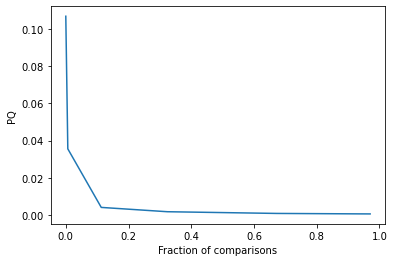

In [39]:
plt.plot(calcAvgList(fraction_comp_list2), calcAvgList(PQ_list2))
plt.ylabel('PQ')
plt.xlabel('Fraction of comparisons')

<function matplotlib.pyplot.show(close=None, block=None)>

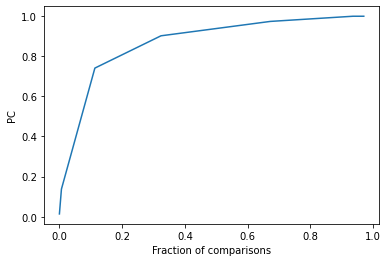

In [38]:
plt.plot(calcAvgList(fraction_comp_list2), calcAvgList(PC_list2))
plt.ylabel('PC')
plt.xlabel('Fraction of comparisons')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

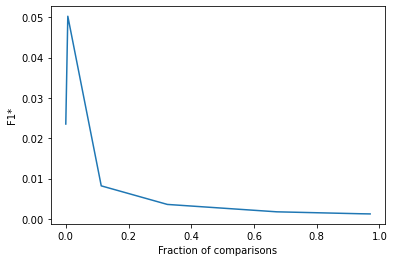

In [41]:
plt.plot(calcAvgList(fraction_comp_list2), calcAvgList(F1_star_list2))
plt.ylabel('F1*')
plt.xlabel('Fraction of comparisons')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

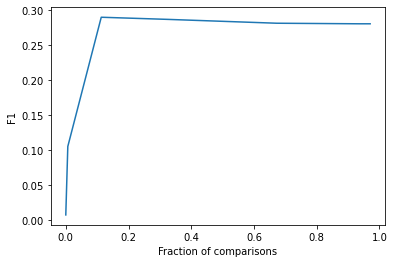

In [52]:
plt.plot(calcAvgList(fraction_comp_list2), calcAvgList(F1_MSM_list2))
list = [np.average(F1_MSM_list_benchmarklist), np.average(F1_MSM_list_benchmarklist), np.average(F1_MSM_list_benchmarklist), np.average(F1_MSM_list_benchmarklist), np.average(F1_MSM_list_benchmarklist), np.average(F1_MSM_list_benchmarklist), np.average(F1_MSM_list_benchmarklist)]
# plt.plot(calcAvgList(fraction_comp_list2), list)
plt.ylabel('F1')
plt.xlabel('Fraction of comparisons')
# plt.legend(['TSQS with LSH', 'TSQS without LSH'])
plt.show